In [1]:
from growing_instability_lib import *

Using TensorFlow backend.


In [2]:
sample_sub = pd.read_csv('../data/sampleSubmission.csv')
topics = sorted(set(sample_sub.columns.difference(['id'])))

topic2actual = {}
for i in sample_sub.columns:
    if 'id' == i:
        continue
    topic2actual[i] = segment(i)
    
target_columns = sorted(topics)
len(topics)

160

In [3]:
%%time
wvec_trainingX = pd.read_hdf('training_data_wv_fs_lsi_no_stopwords.hdf', 'wvec_trainingX')
fvec_trainingX = pd.read_hdf('training_data_wv_fs_lsi_no_stopwords.hdf', 'fvec_trainingX')

tfidf_wvec_trainingX = pd.read_hdf('training_data_wv_fs_lsi_no_stopwords.hdf', 'tfidf_wvec_trainingX')
tfidf_fvec_trainingX = pd.read_hdf('training_data_wv_fs_lsi_no_stopwords.hdf', 'tfidf_fvec_trainingX')
tfidf_lsi_trainingX = pd.read_hdf('training_data_wv_fs_lsi_no_stopwords.hdf', 'tfidf_lsi_trainingX')

word2idx_trainingX = pd.read_hdf('training_data_wv_fs_lsi_no_stopwords.hdf', 'word2idx_trainingX')
_word2idx = pd.read_hdf('training_data_wv_fs_lsi_no_stopwords.hdf', '_word2idx')
trainingY = pd.read_hdf('training_data_wv_fs_lsi_no_stopwords.hdf', 'trainingY')

CPU times: user 10.3 s, sys: 3.74 s, total: 14 s
Wall time: 18.1 s


In [4]:
# https://192.168.1.25:9999/notebooks/kaggle/data-science-challenge-growing-instability-05-13-2017/src/Topic%20Modeling%20and%20Clustering.ipynb
train_test_df = pd.read_hdf('train_test_df_3.hdf', 'train_test_df')

In [5]:
def transform_topics(df, topics):
    topics = sorted(topics)
#     v = np.zeros(shape=(df.shape[0], len(topics)))
    v = []
    for ix, tp in enumerate(df.topics):
        tt = []
        for t in tp:
            tt.append(topics.index(t))
#             v[ix][topics.index(t)] = 1
        v.append(tt)

    return pd.Series(v, index=df.index)

In [15]:
train_test_word_indices, train_test_wvec, train_test_fvec, train_test_tfidf_wvec, train_test_tfidf_fvec, train_test_tfidf_lsi = extract_features_for(
    train_test_df
)

train_test_y = transform_topics(train_test_df, topics)

Computing fs features...
Current batch in main thread: 102
Current batch in main thread: 221
Computing wv features...
Current batch in main thread: 102
Current batch in main thread: 221
Mapping word indices...
Computing tfidf fs features...
Current batch in main thread: 102
Current batch in main thread: 221
Computing tfidf wv features...
Current batch in main thread: 102
Current batch in main thread: 221
Computing tfidf lsi features...
Current batch in main thread: 102
Current batch in main thread: 221


In [16]:
%%time
ind2word = {j:i for i, j in _word2idx.iteritems()}
ind2class = dict(enumerate(topics))
class2ind = {j: i for i, j in ind2class.items()}

num_samples = trainingY.shape[0]

# ---------------------------------
training_X = word2idx_trainingX.head(num_samples)
training_Y = pd.DataFrame(zip(*np.where(trainingY.head(num_samples) == 1)), columns=['iloc', 'topics'])

training_WV = wvec_trainingX.head(num_samples)
training_FS = fvec_trainingX.head(num_samples)

training_tfidf_WV = tfidf_wvec_trainingX.head(num_samples)
training_tfidf_FS = tfidf_fvec_trainingX.head(num_samples)
training_tfidf_LSI = tfidf_lsi_trainingX.head(num_samples)
# ---------------------------------


# ---------------------------------
training_Y = training_Y.groupby('iloc')['topics'].apply(list)
training_Y.index = trainingY.head(num_samples).index

indices = sorted(training_Y.index[training_Y.index.str.contains('^201[0-9]')])
# np.random.shuffle(indices)
indices = pd.Index(indices)
# ---------------------------------


# ---------------------------------
training_X = training_X.ix[indices]
training_Y = training_Y.ix[indices]

training_WV = training_WV.ix[indices]
training_FS = training_FS.ix[indices]

training_tfidf_WV = training_tfidf_WV.ix[indices]
training_tfidf_FS = training_tfidf_FS.ix[indices]
training_tfidf_LSI = training_tfidf_LSI.ix[indices]
# ---------------------------------

CPU times: user 10.9 s, sys: 328 ms, total: 11.2 s
Wall time: 11.2 s


In [17]:
%%time
wv_sc = StandardScaler()
fs_sc = StandardScaler()

tfidf_wv_sc = StandardScaler()
tfidf_fs_sc = StandardScaler()
tfidf_lsi_sc = StandardScaler()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.82 µs


In [88]:
%%time

from keras.preprocessing import sequence
maxlen = 500


def build_target(y, size):
    e = np.zeros(size)
    e[y] = 1
    return e


def build_input_output_data(X, WV, FS, TWV, TFS, TLSI, Y, maxlen):
    x = sequence.pad_sequences(X, maxlen=maxlen)
    y = np.vstack(Y.map(lambda x: build_target(x, len(topics))))

    wv = np.vstack(WV)
    fs = np.vstack(FS)

    twv = np.vstack(TWV)
    tfs = np.vstack(TFS)
    tlsi = np.vstack(TLSI)

    return x, wv, fs, twv, tfs, tlsi, y


# ---------------------------------
train_ix = training_Y.index.str.contains('^201[2-4]')
val_ix = training_Y.index.str.contains('^2014[b]')
# ---------------------------------


# ---------------------------------
x_train, wv_train, fs_train, tfidf_wv_train, tfidf_fs_train, tfidf_lsi_train, y_train = build_input_output_data(
    training_X.ix[train_ix],

    training_WV.ix[train_ix],
    training_FS.ix[train_ix],

    training_tfidf_WV.ix[train_ix],
    training_tfidf_FS.ix[train_ix],
    training_tfidf_LSI.ix[train_ix],

    training_Y.ix[train_ix],
    maxlen=maxlen
)
# ---------------------------------


# ---------------------------------
x_val, wv_val, fs_val, tfidf_wv_val, tfidf_fs_val, tfidf_lsi_val, y_val = build_input_output_data(
    training_X.ix[val_ix],

    training_WV.ix[val_ix],
    training_FS.ix[val_ix],

    training_tfidf_WV.ix[val_ix],
    training_tfidf_FS.ix[val_ix],
    training_tfidf_LSI.ix[val_ix],

    training_Y.ix[val_ix],
    maxlen=maxlen
)
# ---------------------------------

CPU times: user 1.8 s, sys: 140 ms, total: 1.94 s
Wall time: 1.93 s


In [89]:
# ---------------------------------
train_test_x_train, train_test_wv_train, train_test_fs_train, train_test_tfidf_wv_train, train_test_tfidf_fs_train, train_test_tfidf_lsi_train, train_test_y_train = build_input_output_data(
    train_test_word_indices,

    train_test_wvec,
    train_test_fvec,

    train_test_tfidf_wvec,
    train_test_tfidf_fvec,
    train_test_tfidf_lsi,

    train_test_y,
    maxlen=maxlen
)
# ---------------------------------

In [90]:
def upsample(x, N=3):
    return np.vstack([x for i in xrange(N)])

In [91]:
tt_x_train = np.vstack([x_train, upsample(train_test_x_train)])

tt_wv_train = np.vstack([wv_train, upsample(train_test_wv_train)])
tt_fs_train = np.vstack([fs_train, upsample(train_test_fs_train)])

tt_tfidf_wv_train = np.vstack([tfidf_wv_train, upsample(train_test_tfidf_wv_train)])
tt_tfidf_fs_train = np.vstack([tfidf_fs_train, upsample(train_test_tfidf_fs_train)])
tt_tfidf_lsi_train = np.vstack([tfidf_lsi_train, upsample(train_test_tfidf_lsi_train)])

tt_y_train = np.vstack([y_train, upsample(train_test_y_train)])

In [92]:
# ---------------------------------
wv_train = wv_sc.fit_transform(wv_train)
fs_train = fs_sc.fit_transform(fs_train)

tfidf_wv_train = tfidf_wv_sc.fit_transform(tfidf_wv_train)
tfidf_fs_train = tfidf_fs_sc.fit_transform(tfidf_fs_train)
tfidf_lsi_train = tfidf_lsi_sc.fit_transform(tfidf_lsi_train)
# ---------------------------------


# ---------------------------------
wv_val = wv_sc.transform(wv_val)
fs_val = fs_sc.transform(fs_val)

tfidf_wv_val = tfidf_wv_sc.transform(tfidf_wv_val)
tfidf_fs_val = tfidf_fs_sc.transform(tfidf_fs_val)
tfidf_lsi_val = tfidf_lsi_sc.transform(tfidf_lsi_val)
# ---------------------------------

In [93]:
# ---------------------------------
tt_wv_train = wv_sc.transform(tt_wv_train)
tt_fs_train = fs_sc.transform(tt_fs_train)

tt_tfidf_wv_train = tfidf_wv_sc.transform(tt_tfidf_wv_train)
tt_tfidf_fs_train = tfidf_fs_sc.transform(tt_tfidf_fs_train)
tt_tfidf_lsi_train = tfidf_lsi_sc.transform(tt_tfidf_lsi_train)
# ---------------------------------

In [22]:
training_Y.shape, training_Y.ix[training_Y.index.str.contains('^2014[b]')].shape

((94731,), (9424,))

In [23]:
q = pd.DataFrame(y_train, columns=topics).sum()  #, index=training_Y.ix[train_ix].index).sum()

In [25]:
q[q == 0]

activism                       0.0
bastilledaytruckattack         0.0
berlinchristmasmarketattack    0.0
brusselsattacks                0.0
charliehebdoattack             0.0
francetrainattack              0.0
munichshooting                 0.0
orlandoterrorattack            0.0
parisattacks                   0.0
peaceandreconciliation         0.0
sanbernardinoshooting          0.0
tunisiaattack2015              0.0
turkeycoupattempt              0.0
zikavirus                      0.0
dtype: float64

In [27]:
# print q[q > 0]['parisattacks']

In [28]:
# Compute for co-occurence probability and apply to the predictions

In [29]:
y_train.sum(axis=1)

array([ 1.,  2.,  1., ...,  3.,  1.,  2.])

In [30]:
import tensorflow as K
import keras.backend as KB


def f1_micro(y_true, y_pred):
    TP = K.metrics.true_positives(y_true, K.round(y_pred))
    FP = K.metrics.false_positives(y_true, K.round(y_pred))
    FN = K.metrics.false_negatives(y_true, K.round(y_pred))
    
    p = K.reduce_sum(TP) / (K.reduce_sum(TP) + K.reduce_sum(FP))
    r = K.reduce_sum(TP) / (K.reduce_sum(TP) + K.reduce_sum(FN))
    
    return (2.0 * p * r) / (p + r)


def f1_score(y_true, y_pred):
    # http://stackoverflow.com/questions/43345909/when-using-mectrics-in-model-compile-in-keras-report-valueerror-unknown-metr
    # Count positive samples.
    c1 = KB.sum(KB.round(KB.clip(y_true * y_pred, 0, 1)))
    c2 = KB.sum(KB.round(KB.clip(y_pred, 0, 1)))
    c3 = KB.sum(KB.round(KB.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    # How many selected items are relevant?
    precision = c1 / c2

    # How many relevant items are selected?
    recall = c1 / c3

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

In [31]:
from keras.layers import Input, Embedding, LSTM, Dense, Dropout, Convolution1D, MaxPooling1D, Flatten
from keras.models import Model
import itertools as it


def build_deep_input_stack(input_node):
    x = Dense(128, activation='tanh')(input_node)
    x = Dropout(0.1)(x)
    x = Dense(256, activation='relu')(input_node)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.1)(x)
    return x


def entangle_inputs(input_nodes=[]):
    assert(len(input_nodes) > 1)
    
    entangled_inputs = []

    for n1, n2 in it.combinations(input_nodes, 2):
        entangled_inputs.append(
            keras.layers.dot([n1, n2], 1, normalize=True)
        )
    
    return entangled_inputs


wv_input = Input(shape=(300,), name='wv_input')
fs_input = Input(shape=(300,), name='fs_input')

tfidf_wv_input = Input(shape=(300,), name='tfidf_wv_input')
tfidf_fs_input = Input(shape=(300,), name='tfidf_fs_input')
tfidf_lsi_input = Input(shape=(300,), name='tfidf_lsi_input')


wv_x = build_deep_input_stack(wv_input)
fs_x = build_deep_input_stack(fs_input)
tfidf_wv_x = build_deep_input_stack(tfidf_wv_input)
tfidf_fs_x = build_deep_input_stack(tfidf_fs_input)
tfidf_lsi_x = build_deep_input_stack(tfidf_wv_input)

stacked_inputs_x = [wv_x, fs_x, tfidf_wv_x, tfidf_fs_x, tfidf_lsi_x]
# stacked_inputs_x = [tfidf_wv_x, tfidf_fs_x, tfidf_lsi_x]
entangled_inputs_x = entangle_inputs(stacked_inputs_x)

x = keras.layers.concatenate(stacked_inputs_x + entangled_inputs_x)

# We stack a deep densely-connected network on top
x = Dense(128, activation='tanh')(x)
x = Dropout(0.1)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.1)(x)

# And finally we add the main logistic regression layer
main_output = Dense(len(class2ind), activation='sigmoid', name='main_output')(x)

model = Model(
    inputs=[
        wv_input,
        fs_input,
        tfidf_wv_input,
        tfidf_fs_input,
        tfidf_lsi_input,
    ],
    outputs=[main_output]
)

model.compile(
    optimizer='rmsprop',  # keras.optimizers.RMSprop(lr=0.005),  # , rho=0.9, epsilon=1e-08, decay=0.0, clipnorm=1),
    loss={'main_output': 'categorical_crossentropy'},
    loss_weights={'main_output': 1.},
    metrics=['accuracy', f1_micro]
)

model.summary()

In [94]:
from keras.layers import Input, Embedding, LSTM, Dense, Dropout, Convolution1D, MaxPooling1D, Flatten
from keras.models import Model
import itertools as it


def build_deep_input_stack(input_node):
    x = Dense(128, activation='tanh')(input_node)
    x = Dropout(0.1)(x)
    x = Dense(256, activation='relu')(input_node)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.1)(x)
    return x


def entangle_inputs(input_nodes=[]):
    assert(len(input_nodes) > 1)
    
    entangled_inputs = []

    for n1, n2 in it.combinations(input_nodes, 2):
        entangled_inputs.append(
            keras.layers.dot([n1, n2], 1, normalize=True)
        )
    
    return entangled_inputs


test_wv_input = Input(shape=(300,), name='wv_input')
test_fs_input = Input(shape=(300,), name='fs_input')

test_tfidf_wv_input = Input(shape=(300,), name='tfidf_wv_input')
test_tfidf_fs_input = Input(shape=(300,), name='tfidf_fs_input')
test_tfidf_lsi_input = Input(shape=(300,), name='tfidf_lsi_input')


test_wv_x = build_deep_input_stack(test_wv_input)
test_fs_x = build_deep_input_stack(test_fs_input)
test_tfidf_wv_x = build_deep_input_stack(test_tfidf_wv_input)
test_tfidf_fs_x = build_deep_input_stack(test_tfidf_fs_input)
test_tfidf_lsi_x = build_deep_input_stack(test_tfidf_wv_input)

test_stacked_inputs_x = [test_wv_x, test_fs_x, test_tfidf_wv_x, test_tfidf_fs_x, test_tfidf_lsi_x]
# stacked_inputs_x = [tfidf_wv_x, tfidf_fs_x, tfidf_lsi_x]
test_entangled_inputs_x = entangle_inputs(test_stacked_inputs_x)

test_x = keras.layers.concatenate(test_stacked_inputs_x + test_entangled_inputs_x)

# We stack a deep densely-connected network on top
test_x = Dense(128, activation='tanh')(test_x)
test_x = Dropout(0.1)(test_x)
test_x = Dense(256, activation='relu')(test_x)
test_x = Dropout(0.1)(test_x)
test_x = Dense(256, activation='relu')(test_x)
test_x = Dropout(0.1)(test_x)
test_x = Dense(128, activation='relu')(test_x)
test_x = Dropout(0.1)(test_x)

# And finally we add the main logistic regression layer
test_main_output = Dense(len(class2ind), activation='sigmoid', name='main_output')(test_x)

test_model = Model(
    inputs=[
        test_wv_input,
        test_fs_input,
        test_tfidf_wv_input,
        test_tfidf_fs_input,
        test_tfidf_lsi_input,
    ],
    outputs=[test_main_output]
)

test_model.compile(
    optimizer='rmsprop',  # keras.optimizers.RMSprop(lr=0.005),  # , rho=0.9, epsilon=1e-08, decay=0.0, clipnorm=1),
    loss={'main_output': 'categorical_crossentropy'},
    loss_weights={'main_output': 1.},
    metrics=['accuracy', f1_micro]
)

test_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
wv_input (InputLayer)            (None, 300)           0                                            
____________________________________________________________________________________________________
fs_input (InputLayer)            (None, 300)           0                                            
____________________________________________________________________________________________________
tfidf_wv_input (InputLayer)      (None, 300)           0                                            
____________________________________________________________________________________________________
tfidf_fs_input (InputLayer)      (None, 300)           0                                            
___________________________________________________________________________________________

In [95]:
def build_training_inputs(wv, fs, tfidf_wv, tfidf_fs, tfidf_lsi):
    training_inputs = {
        'wv_input': wv,
        'fs_input': fs,
        'tfidf_wv_input': tfidf_wv,
        'tfidf_fs_input': tfidf_fs,
        'tfidf_lsi_input': tfidf_lsi,
    }
    
    return training_inputs
    

training_inputs = build_training_inputs(
    wv_train,
    fs_train,
    tfidf_wv_train,
    tfidf_fs_train,
    tfidf_lsi_train,
)

training_outputs = {
    'main_output': y_train,
}


tt_training_inputs = build_training_inputs(
    tt_wv_train,
    tt_fs_train,
    tt_tfidf_wv_train,
    tt_tfidf_fs_train,
    tt_tfidf_lsi_train,
)

tt_training_outputs = {
    'main_output': tt_y_train,
}


validation_data=(
    build_training_inputs(
        wv_val,
        fs_val,
        tfidf_wv_val,
        tfidf_fs_val,
        tfidf_lsi_val,
    ),
    {
        'main_output': y_val,
    }
)

In [ ]:
%%time
# And trained it via:
batch_size = 1000
epochs = 100

hist = model.fit(
    training_inputs,
    training_outputs,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2,
    validation_data=validation_data,
)

Train on 56877 samples, validate on 9424 samples
Epoch 1/100
56877/56877 [==============================] - 1s - loss: 1.2976 - acc: 0.7517 - f1_micro: 0.7575 - val_loss: 1.1297 - val_acc: 0.7928 - val_f1_micro: 0.7580
Epoch 2/100
43000/56877 [=====================>........] - ETA: 0s - loss: 1.3010 - acc: 0.7536 - f1_micro: 0.7584

In [ ]:
%%time
# And trained it via:
batch_size = 1000
epochs = 100

tt_hist = test_model.fit(
    tt_training_inputs,
    tt_training_outputs,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2,
    validation_data=validation_data,
)

Train on 57243 samples, validate on 9424 samples
Epoch 1/100
57243/57243 [==============================] - 2s - loss: 5.5912 - acc: 0.1311 - f1_micro: 0.0623 - val_loss: 4.1323 - val_acc: 0.3859 - val_f1_micro: 0.0986
Epoch 2/100
57243/57243 [==============================] - 1s - loss: 3.6871 - acc: 0.4257 - f1_micro: 0.1272 - val_loss: 3.1396 - val_acc: 0.5214 - val_f1_micro: 0.1534
Epoch 3/100
57243/57243 [==============================] - 1s - loss: 3.1277 - acc: 0.5146 - f1_micro: 0.1772 - val_loss: 2.8967 - val_acc: 0.5552 - val_f1_micro: 0.1998
Epoch 4/100
57243/57243 [==============================] - 1s - loss: 2.8610 - acc: 0.5510 - f1_micro: 0.2206 - val_loss: 2.6817 - val_acc: 0.5861 - val_f1_micro: 0.2402
Epoch 5/100
57243/57243 [==============================] - 1s - loss: 2.6815 - acc: 0.5749 - f1_micro: 0.2582 - val_loss: 2.5960 - val_acc: 0.6004 - val_f1_micro: 0.2755
Epoch 6/100
57243/57243 [==============================] - 1s - loss: 2.5482 - acc: 0.5919 - f1_micro

In [78]:
hist.history['f1_micro'][-1], hist.history['loss'][-1]

(0.81847799925922604, 1.2065972358170178)

In [98]:
tt_hist.history['f1_micro'][-1], tt_hist.history['loss'][-1]

(0.74855364079020836, 1.3025726030314513)

In [37]:
# model = keras.models.load_model(
#     'models/lstm-word2vec-fasttext_2010-2014-data_categorical-crossentropy-2014-b-val-standard_scaled_wv_fs.model',
#     custom_objects={'f1_micro': f1_micro}
# )

In [99]:
g = test_model.predict(
    build_training_inputs(
        wv_train,
        fs_train,
        tfidf_wv_train,
        tfidf_fs_train,
        tfidf_lsi_train,
    )
)

In [63]:
from sklearn.metrics import f1_score as sk_f1_score

In [64]:
%%time
dt = 0.01
s = 0.0
e = 0.6
th = np.arange(s, e + dt, dt)
mean_fscores = []
for t in th:
#     fscores = []
#     for ix in range(g.shape[0]):
#         y_a = y_train[ix]
#         y_p = 1.0 * (g[ix] > t)
#         fscores.append(sk_f1_score(y_a, y_p))
#     mean_fscores.append(np.mean(fscores))
    %time mean_fscores.append((t, sk_f1_score(y_train, 1.0 * (g > t), average='micro')))

CPU times: user 896 ms, sys: 20 ms, total: 916 ms
Wall time: 915 ms
CPU times: user 420 ms, sys: 16 ms, total: 436 ms
Wall time: 430 ms
CPU times: user 420 ms, sys: 8 ms, total: 428 ms
Wall time: 428 ms
CPU times: user 420 ms, sys: 8 ms, total: 428 ms
Wall time: 428 ms
CPU times: user 432 ms, sys: 0 ns, total: 432 ms
Wall time: 428 ms
CPU times: user 432 ms, sys: 0 ns, total: 432 ms
Wall time: 427 ms
CPU times: user 412 ms, sys: 16 ms, total: 428 ms
Wall time: 427 ms
CPU times: user 432 ms, sys: 0 ns, total: 432 ms
Wall time: 426 ms
CPU times: user 444 ms, sys: 12 ms, total: 456 ms
Wall time: 452 ms
CPU times: user 432 ms, sys: 20 ms, total: 452 ms
Wall time: 449 ms
CPU times: user 440 ms, sys: 12 ms, total: 452 ms
Wall time: 448 ms
CPU times: user 452 ms, sys: 0 ns, total: 452 ms
Wall time: 448 ms
CPU times: user 448 ms, sys: 0 ns, total: 448 ms
Wall time: 445 ms
CPU times: user 420 ms, sys: 8 ms, total: 428 ms
Wall time: 428 ms
CPU times: user 424 ms, sys: 8 ms, total: 432 ms
Wall ti

In [65]:
thresh, thresh_score = sorted(mean_fscores, key=lambda x: x[1], reverse=True)[0]
thresh, thresh_score

(0.56000000000000005, 0.95136369056745207)

In [66]:
training_Y.ix[train_ix].iloc[15]

[78, 87, 125, 136, 150]

In [108]:
topics[76]

'iraq'

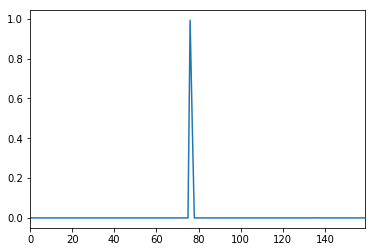

In [106]:
%matplotlib inline
ix = 15
sd = -20
pd.Series(g[sd:][ix]).plot()

In [107]:
# thresh = 0.5
np.where(y_train[sd:][ix] == 1), np.where(g[sd:][ix] > thresh)

((array([76]),), (array([76]),))

In [6]:
from gensim.models.tfidfmodel import TfidfModel
from gensim.models.lsimodel import LsiModel
from gensim.corpora import Dictionary

In [7]:
dictionary = TfidfModel.load('corpus/train_body_data-with_labels_False-retain_special_chars_False.with_test_data.csv.dictionary')
tfidf = TfidfModel.load('corpus/train_body_data-with_labels_False-retain_special_chars_False.with_test_data.csv.tfidf')
lsi = LsiModel.load('corpus/train_body_data-with_labels_False-retain_special_chars_False.with_test_data.csv.lsi')

In [8]:
wvmodel = Word2Vec.load('corpus/train_body_data-with_labels_False-retain_special_chars_False.with_test_data.csv.w2v.model')

In [9]:
fsmodel = fasttext.load_model('corpus/train_body_data-with_labels_False-retain_special_chars_False.with_test_data.csv.fasttext.model.bin')

In [10]:
_fsmodel_cache = {}
def get_fsvec(word):
    if word in _fsmodel_cache:
        fv = _fsmodel_cache[word]
    else:
        fv = fsmodel[word]
        _fsmodel_cache[word] = fv

    return fv

In [11]:
def transform_tfidf_word2vec(tokens, stopwords=[]):
#     global wvmodel
#     global tfidf
    # This requires wvmodel to be present in the namespace.
    wv_feature_vec = tokens.map(
        lambda x: [w for w in x.split() if (w not in stopwords and w in wvmodel.wv.vocab)]
    ).map(
        lambda x: tfidf[dictionary.doc2bow(x)]
    ).map(
        lambda x: np.array([wvmodel[dictionary.id2token[id]] * w for id, w in x]).mean(axis=0) if len(x) > 0 else np.nan
    )

    return wv_feature_vec


def transform_tfidf_fasttext(tokens, stopwords=[]):
#     global fsmodel
#     global tfidf
    # This requires wvmodel to be present in the namespace.
    fs_feature_vec = tokens.map(
        lambda x: [w for w in x.split() if (w not in stopwords)]
    ).map(
        lambda x: tfidf[dictionary.doc2bow(x)]
    ).map(
        lambda x: np.array([np.array(get_fsvec(dictionary.id2token[id])) * w for id, w in x]).mean(axis=0) if len(x) > 0 else np.nan
    )

    return fs_feature_vec


def build_lsi_vector(l):
    v = np.zeros(lsi.num_topics)
    
    for ix, vv in lsi[tfidf[dictionary.doc2bow(l)]]:
        v[ix] = vv
        
    return v


def transform_tfidf_lsi(tokens, stopwords=[]):
#     global fsmodel
#     global tfidf
    # This requires wvmodel to be present in the namespace.
    lsi_feature_vec = tokens.map(
        lambda x: [w for w in x.split() if (w not in stopwords)]
    ).map(
        lambda x: build_lsi_vector(x) if len(x) > 0 else np.nan
    )

    return lsi_feature_vec


def transform_fasttext(tokens, stopwords=[]):
    global fsmodel
    # This requires fsmodel to be present in the namespace.
    fs_feature_vec = tokens.map(
        lambda x: [w for w in x.split() if (w not in stopwords)]
    ).map(lambda x: np.array([get_fsvec(w) for w in x]).mean(axis=0) if len(x) > 0 else np.nan)

    return fs_feature_vec


def transform_unsupervised_sentiment_neuron(tokens, stopwords=[]):
    # This requires fsmodel to be present in the namespace.
    
    usn_feature_vec = usnmodel.transform(tokens)

    # usn_feature_vec = tokens.map(
    #     lambda x: [w for w in x.split() if (w not in stopwords)]
    # ).map(lambda x: np.array([usnmodel[w] for w in x]).mean(axis=0) if len(x) > 0 else np.nan)

    return usn_feature_vec


def transform_word2vec(tokens, stopwords=[]):
    global wvmodel
    # This requires wvmodel to be present in the namespace.
    wv_feature_vec = tokens.map(
        lambda x: [w for w in x.split() if (w not in stopwords and w in wvmodel.wv.vocab)]
    ).map(lambda x: np.array([wvmodel[w] for w in x]).mean(axis=0) if len(x) > 0 else np.nan)

    return wv_feature_vec


def parallel_generate_word_vectors(samp, transformer, stopwords, batch, num_proc):
    with Parallel(n_jobs=num_proc) as parallel:
        dataset = []
        is_break = False
        i = 0

        while not is_break:
            payload = []

            for j in xrange(num_proc):
                t_df = samp[(i + j) * batch: (i + 1 + j) * batch]

                if t_df.empty:
                    is_break = True
                    continue

                payload.append(
                    delayed(transformer)(
                        t_df, stopwords
                    )
                )

            print('Current batch in main thread: {}'.format((i + j) * batch))

            if payload:
                results = parallel(payload)
                dataset.extend(results)
                i += num_proc

    return pd.concat(dataset)


In [12]:
def get_classes(pred, scale_param=0.75, min_thresh=0.05, thresh = 0.5):
#     mx = pred.mean() + 3 * pred.std()
    return np.where(pred > thresh)[0]  

In [13]:
def word2idx_transform(word, _word2idx):
    return _word2idx.get(word, 0)


In [14]:
def extract_features_for(df, min_batch=2000, stopwords=[], num_proc=7):
    df_tokens = transform_text(df)
    
    batch = min(df_tokens.shape[0] / num_proc, min_batch)

    print('Computing fs features...')
    fvec = parallel_generate_word_vectors(df_tokens, transform_fasttext, stopwords=stopwords, batch=batch, num_proc=num_proc)

    print('Computing wv features...')
    wvec = parallel_generate_word_vectors(df_tokens, transform_word2vec, stopwords=stopwords, batch=batch, num_proc=num_proc)

    print('Mapping word indices...')
    word_indices = df_tokens.map(lambda x: [word2idx_transform(i, _word2idx) for i in x.split()])

    print('Computing tfidf fs features...')
    tfidf_fvec = parallel_generate_word_vectors(df_tokens, transform_tfidf_fasttext, stopwords=stopwords, batch=batch, num_proc=num_proc)

    print('Computing tfidf wv features...')
    tfidf_wvec = parallel_generate_word_vectors(df_tokens, transform_tfidf_word2vec, stopwords=stopwords, batch=batch, num_proc=num_proc)

    print('Computing tfidf lsi features...')
    tfidf_lsi = parallel_generate_word_vectors(df_tokens, transform_tfidf_lsi, stopwords=stopwords, batch=batch, num_proc=num_proc)
    
    return word_indices, wvec, fvec, tfidf_wvec, tfidf_fvec, tfidf_lsi

In [45]:
with open('../data/TestData.json') as fl:
    data = json.load(fl)
    test_df = pd.DataFrame(data['TestData']).T
    del(data)

In [46]:
%%time
test_word_indices,test_wvec, test_fvec, test_tfidf_wvec, test_tfidf_fvec, test_tfidf_lsi = extract_features_for(
    test_df
)

Computing fs features...
Current batch in main thread: 6498
Current batch in main thread: 14079
Computing wv features...
Current batch in main thread: 6498
Current batch in main thread: 14079
Mapping word indices...
Computing tfidf fs features...
Current batch in main thread: 6498
Current batch in main thread: 14079
Computing tfidf wv features...
Current batch in main thread: 6498
Current batch in main thread: 14079
Computing tfidf lsi features...
Current batch in main thread: 6498
Current batch in main thread: 14079
CPU times: user 46.8 s, sys: 4.34 s, total: 51.2 s
Wall time: 1min 21s


In [47]:
assert(np.all(test_wvec[test_wvec.isnull()].index == test_fvec[test_fvec.isnull()].index))
test_null_index = test_wvec[test_wvec.isnull()].index.union(test_fvec[test_fvec.isnull()].index)

In [48]:
test_null_index

Index([u'TestData_02543', u'TestData_05012', u'TestData_05830'], dtype='object')

In [49]:
%%time
valid_test_index = test_word_indices.index.difference(test_null_index)
x_test = test_word_indices.ix[valid_test_index]  # .map(lambda x: [top_token2ind.get(i, 0) for i in x])

x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

wv_test = np.vstack(test_wvec.ix[valid_test_index])
fs_test = np.vstack(test_fvec.ix[valid_test_index])

tfidf_wv_test = np.vstack(test_tfidf_wvec.ix[valid_test_index])
tfidf_fs_test = np.vstack(test_tfidf_fvec.ix[valid_test_index])
tfidf_lsi_test = np.vstack(test_tfidf_lsi.ix[valid_test_index])

wv_test = wv_sc.transform(wv_test)
fs_test = fs_sc.transform(fs_test)

tfidf_wv_test = tfidf_wv_sc.transform(tfidf_wv_test)
tfidf_fs_test = tfidf_fs_sc.transform(tfidf_fs_test)
tfidf_lsi_test = tfidf_lsi_sc.transform(tfidf_lsi_test)

test_inputs = build_training_inputs(
    wv_test,
    fs_test,
    tfidf_wv_test,
    tfidf_fs_test,
    tfidf_lsi_test,
)

CPU times: user 356 ms, sys: 20 ms, total: 376 ms
Wall time: 376 ms


In [69]:
test_probas = model.predict(test_inputs, batch_size=batch_size)

In [109]:
tt_test_probas = test_model.predict(test_inputs, batch_size=batch_size)

In [70]:
main_test_probas = test_probas

In [71]:
skip_index = [int(s.split('_')[1]) - 1 for s in test_null_index]  # Subtract 1 since test index starts at 1 while enumerate starts at 0
skip_index

[2542, 5011, 5829]

In [72]:
main_test_probas.shape, test_df.shape

((7578, 160), (7581, 3))

In [73]:
%%time
# valid_test_feature_vec found below!
# thresh = 0.3
test_values = np.zeros([main_test_probas.shape[0], len(topics)])
for ix, pred in enumerate(main_test_probas):
    for v in get_classes(pred, thresh=thresh):
        test_values[ix][v] = 1

test_sub_df = pd.DataFrame(
    test_values,
    index=test_df.ix[test_df.index.difference(test_null_index)].index,
    columns=topics
)

null_test_df = pd.DataFrame(
    np.zeros((len(test_null_index), len(topics))),
    index=test_null_index,
    columns=topics
)

test_sub_df = test_sub_df.append(null_test_df)
test_sub_df = test_sub_df.sort_index()

CPU times: user 32 ms, sys: 4 ms, total: 36 ms
Wall time: 32.6 ms


In [142]:
%%time
# valid_test_feature_vec found below!
thresh = 0.3
test_values = np.zeros([main_test_probas.shape[0], len(topics)])
for ix, pred in enumerate(tt_test_probas):
    for v in get_classes(pred, thresh=thresh):
        test_values[ix][v] = 1

tt_test_sub_df = pd.DataFrame(
    test_values,
    index=test_df.ix[test_df.index.difference(test_null_index)].index,
    columns=topics
)

null_test_df = pd.DataFrame(
    np.zeros((len(test_null_index), len(topics))),
    index=test_null_index,
    columns=topics
)

tt_test_sub_df = tt_test_sub_df.append(null_test_df)
tt_test_sub_df = tt_test_sub_df.sort_index()

CPU times: user 36 ms, sys: 0 ns, total: 36 ms
Wall time: 31.7 ms


In [144]:
tt_test_sub_df.sum().sum()

13311.0

In [74]:
test_sub_df.iloc[3319].sum()

2.0

In [75]:
u = test_sub_df[test_sub_df.berlinchristmasmarketattack == 1]
print u.shape
u.sum().sum()

(0, 160)


0.0

In [76]:
6552, thresh

(6552, 0.56000000000000005)

In [112]:
test_sub_df.sum().sum()

12761.0

In [59]:
test_sub_df.sum()

activism                                    0.0
afghanistan                               126.0
aid                                        60.0
algerianhostagecrisis                      21.0
alqaida                                   165.0
alshabaab                                  35.0
antiwar                                     0.0
arabandmiddleeastprotests                 227.0
armstrade                                  87.0
australianguncontrol                        0.0
australiansecurityandcounterterrorism     100.0
bastilledaytruckattack                      0.0
belgium                                    42.0
berlinchristmasmarketattack                 0.0
bigdata                                    12.0
biometrics                                  0.0
bokoharam                                  38.0
bostonmarathonbombing                      71.0
britisharmy                                 5.0
brusselsattacks                             0.0
cameroon                                

In [126]:
tt_test_sub_df.sum().sum()

9520.0

In [115]:
tt_test_sub_df.sum()

activism                                    0.0
afghanistan                               100.0
aid                                        66.0
algerianhostagecrisis                       9.0
alqaida                                   115.0
alshabaab                                  35.0
antiwar                                     0.0
arabandmiddleeastprotests                 209.0
armstrade                                  80.0
australianguncontrol                        0.0
australiansecurityandcounterterrorism      42.0
bastilledaytruckattack                     24.0
belgium                                     5.0
berlinchristmasmarketattack                21.0
bigdata                                     9.0
biometrics                                  0.0
bokoharam                                  39.0
bostonmarathonbombing                      52.0
britisharmy                                 2.0
brusselsattacks                            50.0
cameroon                                

In [145]:
# 1.1745 - acc: 0.7750 - f1_micro: 0.7891
sub_filename = 'tfidf_wv_300-fs_300-lsi_300-deep_stack_net-low_dropout-rmsprop-epochs_300-tanh_init_activation-f1_{:.4f}-loss_{:.4f}-data_2012_2014_test_augmented_3_upsample-val_data_2014-thresh_{}-with_sc_wv_fs_lsi.csv'.format(hist.history['f1_micro'][-1], hist.history['loss'][-1], thresh)
print sub_filename

tfidf_wv_300-fs_300-lsi_300-deep_stack_net-low_dropout-rmsprop-epochs_300-tanh_init_activation-f1_0.8185-loss_1.2066-data_2012_2014_test_augmented_3_upsample-val_data_2014-thresh_0.3-with_sc_wv_fs_lsi.csv


In [146]:
test_sub_df.astype(int).reset_index().rename(
    columns={'index': 'id'}
).sort_values('id').to_csv(
    sub_filename, 
    index=False
)

In [225]:
test_sub_df.shape

(7581, 160)

In [2]:
import pandas as pd

In [116]:
dfd = pd.read_csv('tfidf_wv_300-fs_300-lsi_300-deep_stack_net-low_dropout-rmsprop-epochs_110-tanh_init_activation-f1_0.7528-data_2012_2014_test_augmented_10_upsample-val_data_2014-thresh_0.48-with_sc_wv_fs_lsi.csv')

In [8]:
dfd.set_index('id').iloc[7262]

3

In [125]:
(dfd.sum() - tt_test_sub_df.sum())

activism                                   0
afghanistan                               -4
aid                                        4
algerianhostagecrisis                     22
alqaida                                   36
alshabaab                                  0
antiwar                                    2
arabandmiddleeastprotests                 30
armstrade                                 -2
australianguncontrol                       0
australiansecurityandcounterterrorism     37
bastilledaytruckattack                   -24
belgium                                   82
berlinchristmasmarketattack              -21
bigdata                                   -1
biometrics                                 2
bokoharam                                 -1
bostonmarathonbombing                     52
britisharmy                                2
brusselsattacks                          -50
cameroon                                   1
carers                                     1
charlieheb

In [ ]:
TestData_04490	The World Health Organisation has convened an ...	[]	28-01-2016
TestData_04550	Spraying pesticides will fail to deal with the...	[]	02-02-2016
TestData_05683	Violent protests at Trump rally in California ...	[]	03-06-2016
TestData_05869	Last weekend, we saw the darkest side of human...	[]	17-06-2016
TestData_06148	As dusk falls over Copacabana beach, Ubira San...	[]	16-07-2016
TestData_06291	It is 3pm and yet another patient is brought t...	[]	27-07-2016
TestData_06610	Huddled around their hives, beekeepers around ...	[]	04-09-2016
TestData_06708	A United Nations high-level panel on access to...	[]	14-09-2016
TestData_07263	WHO: Zika virus is no longer a world threat Th...	[]	19-11-2016
TestData_07478	1 World Health Organisation declares a public ...	[]	18-12-2016

In [82]:
ix = 5868
test_sub_df.iloc[ix][test_sub_df.iloc[ix] == 1]

guncrime        1.0
usguncontrol    1.0
Name: TestData_05869, dtype: float64

In [111]:
# %%time
# adjust_index = 0
# # valid_test_feature_vec found below!
# test_values = np.zeros([test_df.shape[0], len(topics)])
# for ix, pred in enumerate(main_test_probas):
#     if ix in skip_index:
#         test_values[ix] = np.nan
#         # Increment adjust index so that we have the correct index for other samples
#         adjust_index += 1
#         continue

#     for v in get_classes(pred, thresh=0.05):
#         test_values[ix + adjust_index][v] = 1

# test_sub_df = pd.DataFrame(test_values, columns=sorted(topics), index=test_df.index)

# q = test_sub_df.sum(axis=1)
# assert(len(q[q.isnull()].index.difference(test_null_index)) == 0)

# test_sub_df = test_sub_df.fillna(0)

# # for i in test_feature_vec[test_feature_vec.isnull()].index:
# #     test_sub_df.ix[i] = np.zeros(len(topics))

CPU times: user 36 ms, sys: 0 ns, total: 36 ms
Wall time: 32.6 ms


In [40]:
test_sub_df.ix[test_null_index].sum(axis=1)

TestData_02543    0.0
TestData_05012    0.0
TestData_05830    0.0
dtype: float64

In [41]:
test_sub_df.sum().sum()

11656.0

In [124]:
test_sub_df.astype(int).reset_index().rename(
    columns={'index': 'id'}
).sort_values('id').to_csv(
    'lstm_300-word2vec_300-fasttext_300-maxlen_500-dense_64_64_64-cat_cross-epoch_210-batch_size_750-val_main_output_f1_micro_0.5760-main_output_f1_micro_0.5751-main_output_loss_0.9143-data_2010_2013-val_data_2014-thresh_0.05.csv', 
    index=False
)

In [86]:
e = test_sub_df['zikavirus']
e[e==1]

Series([], Name: zikavirus, dtype: float64)

In [87]:
top_submission = pd.read_csv('basic_nn_submission_0.649_accuracy_multi_class.csv')
top_submission.set_index('id').sum().sum()

14328

In [88]:
wrong_index_lstm_sub = pd.read_csv('lstm.2014b_training_700_maxlen_64cell_100epochs_0.0025_threshold.csv')
wrong_index_lstm_sub.set_index('id').sum().sum()

9280

In [89]:
some_sub = pd.read_csv('basic_nn_submission_full_training_data_0.9958_validation_accuracy_binary_crossentropy.csv')
some_sub.set_index('id').sum().sum()

34952

In [90]:
print top_submission.set_index('id')[top_submission.set_index('id').sum(axis=1) == 0].shape

print wrong_index_lstm_sub.set_index('id')[wrong_index_lstm_sub.set_index('id').sum(axis=1) == 0].shape

print some_sub.set_index('id')[some_sub.set_index('id').sum(axis=1) == 0].shape

print test_sub_df[test_sub_df.sum(axis=1) == 0].shape

(2197, 160)
(3957, 160)
(12, 160)
(1503, 160)


In [106]:
top_submission.set_index('id').ix[q[q == 0].index].sum(axis=1)

TestData_00011     0
TestData_00012     0
TestData_00015     0
TestData_00027     3
TestData_00029     0
TestData_00038     1
TestData_00042     5
TestData_00053     4
TestData_00056     1
TestData_00060     1
TestData_00066     0
TestData_00085     0
TestData_00087     1
TestData_00090     0
TestData_00092     0
TestData_00107     3
TestData_00111     0
TestData_00114     0
TestData_00115     1
TestData_00118     0
TestData_00119     0
TestData_00121     0
TestData_00123     0
TestData_00125     0
TestData_00127     0
TestData_00128     1
TestData_00139     1
TestData_00140     1
TestData_00144     0
TestData_00147     2
                  ..
TestData_07445     0
TestData_07456     3
TestData_07461     1
TestData_07462     4
TestData_07465     0
TestData_07468     0
TestData_07471     1
TestData_07475     0
TestData_07486    10
TestData_07495     1
TestData_07509     0
TestData_07514     3
TestData_07515     1
TestData_07523     0
TestData_07533     2
TestData_07534     2
TestData_0754

In [91]:
q = test_sub_df.sum(axis=1)
q[q==0].shape

(1222,)

In [92]:
q.describe()

count    7581.000000
mean        2.160929
std         1.739411
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        13.000000
dtype: float64

In [157]:
q = trainingY.sum(axis=1)

In [158]:
q.describe()

count    236286.000000
mean          1.392787
std           0.762577
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          15.000000
dtype: float64

In [82]:
test_df.sample(5)

,bodyText,topics,webPublicationDate
TestData_03241,A special British police unit was put on stand...,[],15-11-2015
TestData_04088,The youngest convict in a fatal gang-rape in N...,[],20-12-2015
TestData_06306,Former New York City mayor Rudy Giuliani has s...,[],28-07-2016
TestData_06083,"John Cantlie, the British journalist who has b...",[],13-07-2016
TestData_05896,Lawyers for the companies that manufactured an...,[],20-06-2016


In [89]:
test_ix = 'TestData_03241'

In [90]:
q = test_sub_df.ix[test_ix]
q[q>0]

london                1.0
metropolitanpolice    1.0
police                1.0
uksecurity            1.0
Name: TestData_03241, dtype: float64

In [91]:
q = top_submission.set_index('id').ix[test_ix]
q[q>0]

ukcrime    1
Name: TestData_04088, dtype: int64

In [92]:
q = some_sub.set_index('id').ix[test_ix]
q[q>0]

humanrights    1
india          1
protest        1
ukcrime        1
Name: TestData_04088, dtype: int64

In [62]:
q = wrong_index_lstm_sub.set_index('id').ix[test_ix]
q[q>0]

humanrights    1
Name: TestData_02924, dtype: int64

In [ ]:
Counter-terrorism policy
 
Foreign policy
 
Defence policy
 
Islamic State
 
Syria
 
news

In [83]:
s = trainingY.sum()
unseen_topics = s[s.isnull()].index

In [85]:
set(topics).intersection(unseen_topics)

{'activism',
 'bastilledaytruckattack',
 'berlinchristmasmarketattack',
 'brusselsattacks',
 'charliehebdoattack',
 'francetrainattack',
 'munichshooting',
 'orlandoterrorattack',
 'parisattacks',
 'peaceandreconciliation',
 'sanbernardinoshooting',
 'tunisiaattack2015',
 'turkeycoupattempt',
 'zikavirus'}

In [170]:
for i in topics:
    print i

activism
afghanistan
aid
algerianhostagecrisis
alqaida
alshabaab
antiwar
arabandmiddleeastprotests
armstrade
australianguncontrol
australiansecurityandcounterterrorism
bastilledaytruckattack
belgium
berlinchristmasmarketattack
bigdata
biometrics
bokoharam
bostonmarathonbombing
britisharmy
brusselsattacks
cameroon
carers
charliehebdoattack
chemicalweapons
clusterbombs
cobra
conflictanddevelopment
controversy
criminaljustice
cybercrime
cyberwar
darknet
dataprotection
debate
defence
deflation
drones
drugs
drugspolicy
drugstrade
earthquakes
ebola
economy
egypt
encryption
energy
espionage
ethics
europeanarrestwarrant
europeancourtofhumanrights
events
extradition
famine
farright
firefighters
forensicscience
france
francetrainattack
freedomofspeech
genevaconventions
germany
guncrime
hacking
hashtags
helicoptercrashes
humanitarianresponse
humanrights
humanrightsact
humantrafficking
immigration
india
indonesia
internallydisplacedpeople
internationalcourtofjustice
internationalcriminaljustice
in

In [263]:
cosine_similarity(wvmodel['zika'], np.vstack(test_wvec.dropna())).max()

/home/avsolatorio/ml-ai/local/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


0.3445929

In [259]:
cosine_similarity(fsmodel['zika'], np.vstack(test_fvec.dropna())).max()

/home/avsolatorio/ml-ai/local/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


0.38107796869050226

In [251]:
test_df.ix[4488 + 1]

bodyText              The World Health Organisation has convened an ...
topics                                                               []
webPublicationDate                                           28-01-2016
Name: TestData_04490, dtype: object

In [257]:
test_df.ix[6727 + 2]

bodyText              The United Nations security council has called...
topics                                                               []
webPublicationDate                                           17-09-2016
Name: TestData_06730, dtype: object

In [253]:
test_df.ix[359]

bodyText              We are deeply concerned that the counter-terro...
topics                                                               []
webPublicationDate                                           02-02-2015
Name: TestData_00360, dtype: object

In [270]:
q = test_sub_df.iloc[4488 + 1]
q[q > 0]

drugstrade    1.0
Name: TestData_04490, dtype: float64